Name: Layan Alabdullatef

Date: December 3rd, 2023

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


# Load Dataset

In [4]:
root = '/content/drive/MyDrive/Fall 2023/EE 475/project/UI_chestxray/images/' # path for the images

In [ ]:
df = pd.read_csv('./UI_chestxray/indiana_projections.csv') # image information
reports = pd.read_csv('./UI_chestxray/indiana_reports.csv') # radiology reports

In [ ]:
df.head(3)

,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal


In [ ]:
reports.head(3)

,uid,MeSH,Problems,image,indication,comparison,findings,impression
0,1,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,2,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.
2,3,normal,normal,Xray Chest PA and Lateral,"rib pain after a XXXX, XXXX XXXX steps this XX...",NaN,NaN,"No displaced rib fractures, pneumothorax, or p..."


In [ ]:
# merge the two csv files into one via the 'uid' column as primary key
df_all = df.merge(reports, left_on='uid', right_on='uid')

In [ ]:
df_all.head(3)

,uid,filename,projection,MeSH,Problems,image,indication,comparison,findings,impression
0,1,1_IM-0001-4001.dcm.png,Frontal,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
1,1,1_IM-0001-3001.dcm.png,Lateral,normal,normal,Xray Chest PA and Lateral,Positive TB test,None.,The cardiac silhouette and mediastinum size ar...,Normal chest x-XXXX.
2,2,2_IM-0652-1001.dcm.png,Frontal,Cardiomegaly/borderline;Pulmonary Artery/enlarged,Cardiomegaly;Pulmonary Artery,"Chest, 2 views, frontal and lateral",Preop bariatric surgery.,None.,Borderline cardiomegaly. Midline sternotomy XX...,No acute pulmonary findings.


In [ ]:
# for simplification i will consider any diseases as one label 'abnoraml'

df_all["MeSH"] = df_all["MeSH"].apply(lambda x: 'normal' if x == 'normal' else 'abnormal')

### Filter the Dataset

I'm filtering the dataset based on the captions (some captions cannot be used) and image view (as each patient has two views and I only need one for the model)

In [ ]:
df_all.columns # we will be using the 'impression' as our caption

Index(['uid', 'filename', 'projection', 'MeSH', 'Problems', 'image',
       'indication', 'comparison', 'findings', 'impression'],
      dtype='object')

In [ ]:
df_all[df_all['impression'] == ''].index # check if there are empty strings

Index([], dtype='int64')

In [ ]:
rows_nan = df_all[df_all['impression'] != df_all['impression']].index # check if there are nan values
print('number of rows with nan values: ', len(rows_nan))

number of rows with nan values:  52


In [ ]:
pd.isna(df_all['impression']).value_counts() # another way to check the number of rows with nan values

impression
False    7414
True       52
Name: count, dtype: int64

In [ ]:
rows_nan # i will need to remove these rows

Index([  30,   31,  606,  607, 1143, 1144, 1259, 1538, 1539, 1669, 1670, 2025,
       2026, 2125, 2126, 2135, 2136, 2145, 2412, 2419, 2420, 2875, 2876, 2877,
       2934, 3021, 3165, 3166, 3295, 3324, 3325, 3945, 3946, 4849, 5019, 5139,
       5140, 5352, 6051, 6052, 6255, 6256, 6257, 6258, 6274, 6275, 6385, 6386,
       6731, 6732, 7052, 7414],
      dtype='int64')

In [ ]:
# since this is medical data, some information has been redacted and replaces with 'xxxx'
# so, i'll remove the rows with the impressions/captions that includes redacted information as it could confuse the model

rows_redacted = df_all[df_all['impression'].str.contains('XXXX')==True].index
print('number of rows with redacted values: ', len(rows_redacted))

number of rows with redacted values:  1246


In [ ]:
rows_redacted # i will need to remove these rows

Index([   0,    1,   16,   17,   40,   41,   54,   55,   89,   90,
       ...
       7356, 7402, 7403, 7404, 7415, 7416, 7450, 7451, 7454, 7455],
      dtype='int64', length=1246)

In [ ]:
rows_to_drop = rows_redacted.append(rows_nan)

In [ ]:
df_all_updated = df_all.copy()

In [ ]:
df_all_updated = df_all_updated.drop(rows_to_drop, axis='index')

In [ ]:
# The values in the 'projection' column can either be Frontal or Lateral
# Meaning each patient has two chest x-ray views taken
# In this project I will only consider the Frontal view

# drop rows with lateral values
df_all_updated = df_all_updated[~df_all_updated["projection"].str.contains('Lateral')]

In [ ]:
print(f'original length of the dataframe: {len(df_all)}, length after filteration: {len(df_all_updated)}')

original length of the dataframe: 7466, length after filteration: 3157


In [ ]:
df_all_updated.reset_index(inplace=True) # reset index count to start from 0 ... 3156

### Prepare the Dataset CSV
Select only needed columns and a balanced number of samples

In [ ]:
# we don't need the entire csv files when training and testing, we only need a few columns
df_data = df_all_updated[['uid', 'filename', 'projection', 'MeSH', 'impression']]

In [ ]:
# rename the columns
df_data = df_data.rename(columns={'MeSH': 'status', 'impression':'caption'})

In [ ]:
df_data.head(5)

,uid,filename,projection,status,caption
0,2,2_IM-0652-1001.dcm.png,Frontal,abnormal,No acute pulmonary findings.
1,3,3_IM-1384-1001.dcm.png,Frontal,normal,"No displaced rib fractures, pneumothorax, or p..."
2,4,4_IM-2050-1001.dcm.png,Frontal,abnormal,1. Bullous emphysema and interstitial fibrosis...
3,5,5_IM-2117-1003002.dcm.png,Frontal,abnormal,No acute cardiopulmonary abnormality.
4,6,6_IM-2192-1001.dcm.png,Frontal,normal,No acute cardiopulmonary findings.


In [ ]:
df_data.to_csv('UI_chestxray_data.csv') # save the current dataframe

In [ ]:
df_data.status.value_counts() # current values of each class

status
abnormal    1888
normal      1269
Name: count, dtype: int64

In [ ]:
# select 300 samples from each class (normal / abnormal)
# this is due to the large data size and image size and lack of compute power

rows_normal = df_data[df_data['status'] == 'normal'].index
rows_abnormal = df_data[df_data['status']== 'abnormal'].index

rows_normal = rows_normal[:300]
rows_abnormal = rows_abnormal[:300]

rows_selected = rows_normal.append(rows_abnormal)

In [ ]:
df_data = df_data[df_data.index.isin(rows_selected)]

In [ ]:
df_data.reset_index(inplace=True)

In [ ]:
df_data

,index,uid,filename,projection,status,caption
0,0,2,2_IM-0652-1001.dcm.png,Frontal,abnormal,No acute pulmonary findings.
1,1,3,3_IM-1384-1001.dcm.png,Frontal,normal,"No displaced rib fractures, pneumothorax, or p..."
2,2,4,4_IM-2050-1001.dcm.png,Frontal,abnormal,1. Bullous emphysema and interstitial fibrosis...
3,3,5,5_IM-2117-1003002.dcm.png,Frontal,abnormal,No acute cardiopulmonary abnormality.
4,4,6,6_IM-2192-1001.dcm.png,Frontal,normal,No acute cardiopulmonary findings.
...,...,...,...,...,...,...
595,738,912,912_IM-2417-1001.dcm.png,Frontal,normal,1. No acute cardiopulmonary findings.
596,739,913,913_IM-2417-1001.dcm.png,Frontal,normal,Negative for acute cardiopulmonary disease.
597,743,918,918_IM-2420-4004.dcm.png,Frontal,normal,No acute abnormality. .
598,745,920,920_IM-2423-1001.dcm.png,Frontal,normal,No acute cardiopulmonary abnormality.


In [ ]:
df_data.to_csv('UI_chestxray_data_final.csv') # save the csv file again after selection of samples

### Separate into Train and Test

In [ ]:
train_df, test_df = train_test_split(df_data, test_size=0.2) # separate into 80% train, 20% test
# I don't take the class consideration into account here as the number is quite small to make a difference

# include a validation set
train_df, val_df = train_test_split(train_df, test_size=0.13) # 0.13 x 0.8 = 0.10 (10% of the train set)

In [ ]:
# reset the index
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)
# save the csv
train_df.to_csv('train_df.csv')
test_df.to_csv('test_df.csv')
val_df.to_csv('val_df.csv')

# EDA

In [ ]:
train_df[train_df.status == 'normal'].caption.value_counts() # here we see the captions used with normal images

caption
No acute cardiopulmonary abnormality.                            29
No acute cardiopulmonary disease.                                13
No acute cardiopulmonary abnormalities.                          12
No acute cardiopulmonary process.                                 9
No acute cardiopulmonary findings.                                9
                                                                 ..
Negative for acute cardiopulmonary abnormality.                   1
Normal chest exam.                                                1
Unremarkable examination.                                         1
No acute cardiopulmonary abnormality identified.                  1
No acute cardiopulmonary process. No obvious rib fractures. .     1
Name: count, Length: 85, dtype: int64

In [ ]:
train_df[train_df.status == 'abnormal'].caption.value_counts() # here we see the captions used with abnormal images

caption
No acute cardiopulmonary abnormality.                                                                                                                                                                                                                                                                       14
No active disease.                                                                                                                                                                                                                                                                                           8
No acute disease.                                                                                                                                                                                                                                                                                            7
No acute cardiopulmonary process.                                                  

Although the above captions are for abnormal cases the most common captions are quite similar to normal cases, this could be a challenge for the model. Further, although we selected equal number of samples from each class we can see that there are less captions for normal cases as a lot of the images are using the same caption. In contrast, there are a larger number of captions for the 300 abnormal cases we selected.

In [ ]:
# investigate the size of all the images (to see if i need to resize or apply other preprocessing methods)
size_images = dict()
avg_width = 0
avg_height = 0

for dirpath, _, filenames in os.walk(root):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        if path_image[-3:] == 'png': # to avoid errors
            with Image.open(image) as img:
                width, heigth = img.size
                avg_width += width
                avg_height += heigth
                size_images[path_image] = {'width': width, 'heigth': heigth}

print(f'Average width: {avg_width/len(df_data)}, Average height: {avg_height/len(df_data)}')
print(size_images) # all the w,h values

Average width: 2251.55, Average height: 2114.965
{'616_IM-2200-1001.dcm.png': {'width': 2114, 'heigth': 2048}, '80_IM-2333-1001.dcm.png': {'width': 2496, 'heigth': 2048}, '364_IM-1804-1001.dcm.png': {'width': 2048, 'heigth': 2048}, '511_IM-2127-1001.dcm.png': {'width': 2048, 'heigth': 2496}, '598_IM-2190-12012.dcm.png': {'width': 2494, 'heigth': 2048}, '169_IM-0452-1001.dcm.png': {'width': 2048, 'heigth': 2048}, '150_IM-0325-0001-0001.dcm.png': {'width': 2474, 'heigth': 2048}, '899_IM-2407-1001.dcm.png': {'width': 2496, 'heigth': 2048}, '331_IM-1584-1001.dcm.png': {'width': 2496, 'heigth': 2048}, '477_IM-2101-1001.dcm.png': {'width': 2496, 'heigth': 2048}, '470_IM-2099-3001.dcm.png': {'width': 2048, 'heigth': 2496}, '143_IM-0276-1001.dcm.png': {'width': 2244, 'heigth': 2048}, '356_IM-1744-1001.dcm.png': {'width': 2496, 'heigth': 2048}, '785_IM-2325-1001.dcm.png': {'width': 2048, 'heigth': 2048}, '532_IM-2140-1001.dcm.png': {'width': 2496, 'heigth': 2048}, '187_IM-0563-1001.dcm.png': {'

<BarContainer object of 2 artists>

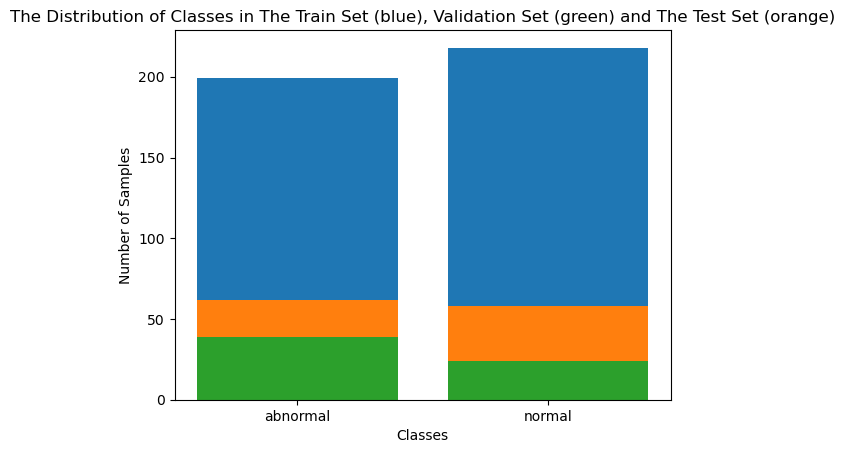

In [ ]:
plt.title('The Distribution of Classes in The Train Set (blue), Validation Set (green) and The Test Set (orange)')
plt.xlabel ('Classes')
plt.ylabel ('Number of Samples')

unique_labels, label_counts = np.unique(train_df.status, return_counts=True)
plt.bar(unique_labels, label_counts)

unique_test_labels, label_test_counts = np.unique(test_df.status, return_counts=True)
plt.bar(unique_test_labels, label_test_counts)

unique_val_labels, label_val_counts = np.unique(val_df.status, return_counts=True)
plt.bar(unique_val_labels, label_val_counts)

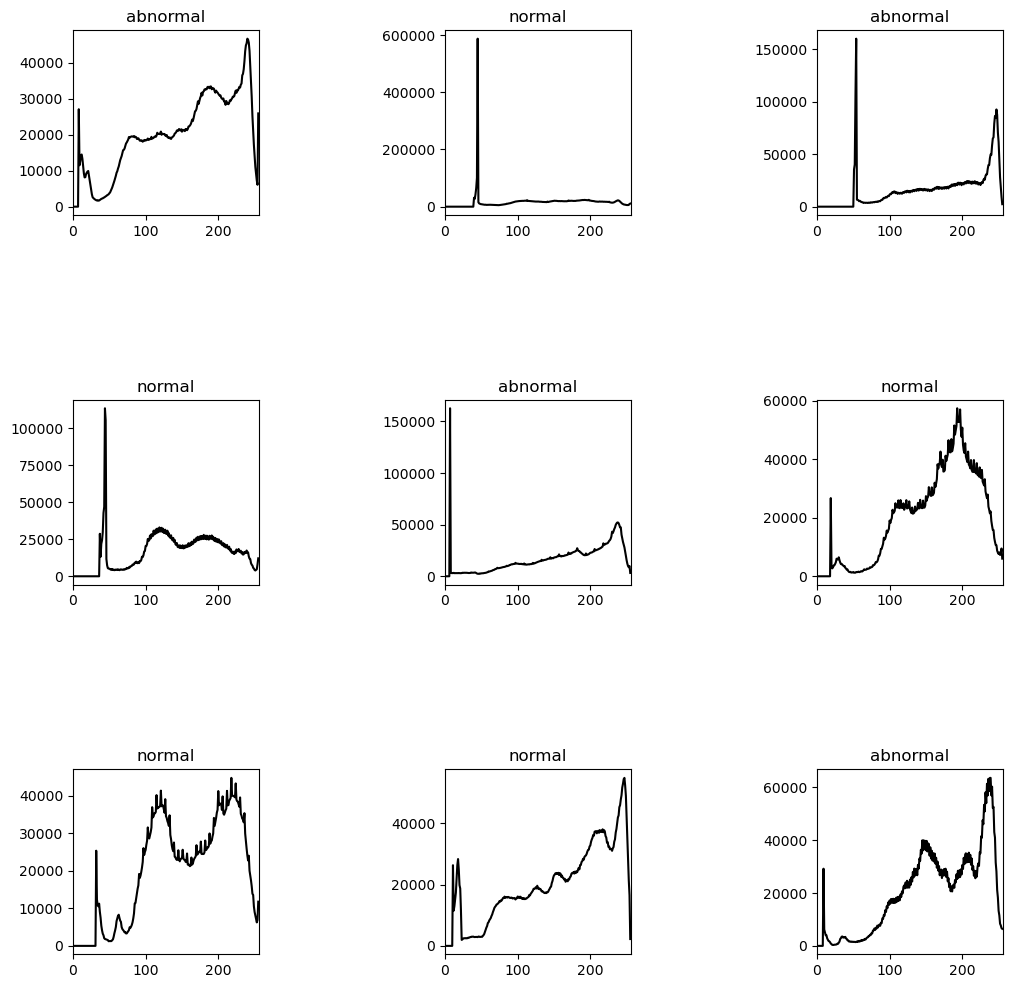

In [ ]:
def showImages_hist_colour(num_row, num_col, dataset):
    '''
    displays the histogram of the pixel values of a sample of images from the train set
    '''
    fig, axes = plt.subplots(num_row, num_col, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(0, num_row * num_col):
        img_path = os.path.join(root, dataset.filename[i])
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = np.asarray(img)
        label = dataset.status[i]

        histogram, bin_edges = np.histogram(
            img, bins=256, range=(0, 256)
        )

        axes[i].set_title("{}".format(label))
        axes[i].plot(bin_edges[0:-1], histogram, color='black')  # Use black color for black and white image
        axes[i].set_xlim([0, 256])
        plt.subplots_adjust(wspace=1, hspace=1)

    plt.show()

    return

showImages_hist_colour(num_row = 3, num_col = 3, dataset = train_df)

from the figure above we can see that the intensity of the pixel values is quite high and differs from each image